In [9]:
# Make BAMS time-series plot of Ft. Myers data from Ap
import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import glob
import os
import string

%run -i scat_stats.py

In [24]:
# Read observations from data downloaded from NOAA on 3/25/2025
# Ft Myers is 8725520. Datum is MSL
data_dir = "F:/crs/proj/2025_NOPP_comparison/BAMS_figure/NOAA/"
fn = 'CO-OPS_8725520_met_MSL_hourly.csv'
dfN = pd.read_csv(data_dir+fn)
# Compute delta_t in seconds
dfN['time'] = pd.to_datetime(dfN['Date'] + ' ' + dfN['Time (GMT)'], format='%Y/%m/%d %H:%M')
delta_t = (dfR["time"].diff().dropna().dt.total_seconds()).iloc[0]
print('Delta_t: ', delta_t)
print(dfN)

          Date Time (GMT)  Predicted (m) Preliminary (m)  Verified (m)
0   2022/09/27      00:00          0.168               -         0.467
1   2022/09/27      01:00          0.106               -         0.403
2   2022/09/27      02:00          0.056               -         0.347
3   2022/09/27      03:00          0.026               -         0.300
4   2022/09/27      04:00          0.030               -         0.306
..         ...        ...            ...             ...           ...
91  2022/09/30      19:00         -0.065               -         0.072
92  2022/09/30      20:00         -0.048               -         0.091
93  2022/09/30      21:00         -0.013               -         0.162
94  2022/09/30      22:00          0.028               -         0.255
95  2022/09/30      23:00          0.069               -         0.338

[96 rows x 5 columns]
Date                object
Time (GMT)          object
Predicted (m)      float64
Preliminary (m)     object
Verified (m)     

In [36]:
# Define the time interval for plot and (shorter) time interval for statistics
# Define the clipping time range
stats_start_time = pd.Timestamp('2022-09-27 12:00:00')
stats_end_time = pd.Timestamp('2022-09-30 00:00:00')

# Define the time interval for plot and (shorter) time interval for statistics
# Define the clipping time range
plot_start_time = pd.Timestamp('2022-09-27 00:00:00')
plot_end_time = pd.Timestamp('2022-09-30 00:00:00')

In [20]:
data_dir = "F:/crs/proj/2025_NOPP_comparison/BAMS_figure/ROMS/"
fn = 'ROMS_FtMyers_water_level.csv'
dfR = pd.read_csv(data_dir+fn)
print(dfR)
print(dfR.dtypes)
# Compute delta_t in seconds
dfR["time"] = pd.to_datetime(dfR["DateTime"])
delta_t = (dfR["time"].diff().dropna().dt.total_seconds()).iloc[0]

print('Delta_t: ', delta_t)

             DateTime  WaterLevel
0    2022-09-26 00:00      0.0785
1    2022-09-26 01:00      0.2026
2    2022-09-26 02:00      0.1506
3    2022-09-26 03:00      0.1889
4    2022-09-26 04:00      0.2621
..                ...         ...
116  2022-09-30 20:00     -0.0686
117  2022-09-30 21:00      0.0217
118  2022-09-30 22:00      0.1183
119  2022-09-30 23:00      0.2104
120  2022-10-01 00:00      0.2645

[121 rows x 2 columns]
DateTime       object
WaterLevel    float64
dtype: object
Delta_t:  3600.0


In [38]:
# Load Deltares data
data_dir = "F:/crs/proj/2025_NOPP_comparison/BAMS_figure/Deltares/"
fn = '8725520.csv'
df = pd.read_csv(data_dir+fn)

df["time"] = pd.to_datetime(df["time"])
print(df.dtypes)
# Compute delta_t in seconds
delta_t = (df["time"].diff().dropna().dt.total_seconds()).iloc[0]
print('Delta_t: ', delta_t)

# Resample to 1 hour using nearest neighbor
# Set 'time' as the index for resampling
df = df.set_index('time')
print(df.index)
df = df.resample('h').nearest()

# Clip to plot times
# Clip to the desired range
df = df.loc[plot_start_time : plot_end_time]

# Reset index to bring 'time' back as a column
df = df.reset_index()
# Recompute delta_t in seconds
delta_t = (df["time"].diff().dropna().dt.total_seconds()).iloc[0]
print('Delta_t: ', delta_t)

time    datetime64[ns]
obs            float64
pred           float64
mod            float64
dtype: object
Delta_t:  600.0
DatetimeIndex(['2022-09-27 00:00:00', '2022-09-27 00:10:00',
               '2022-09-27 00:20:00', '2022-09-27 00:30:00',
               '2022-09-27 00:40:00', '2022-09-27 00:50:00',
               '2022-09-27 01:00:00', '2022-09-27 01:10:00',
               '2022-09-27 01:20:00', '2022-09-27 01:30:00',
               ...
               '2022-09-29 22:30:00', '2022-09-29 22:40:00',
               '2022-09-29 22:50:00', '2022-09-29 23:00:00',
               '2022-09-29 23:10:00', '2022-09-29 23:20:00',
               '2022-09-29 23:30:00', '2022-09-29 23:40:00',
               '2022-09-29 23:50:00', '2022-09-30 00:00:00'],
              dtype='datetime64[ns]', name='time', length=433, freq=None)
Delta_t:  3600.0


In [ ]:
# Find peak timing and value for "obs"
obs_peak_idx = df["obs"].idxmax()  # Index of max value
obs_peak_time = df.loc[obs_peak_idx, "time"]  # Corresponding time
obs_peak_value = df.loc[obs_peak_idx, "obs"]  # Peak value

# Find peak timing and value for "pred"
pred_peak_idx = df["pred"].idxmax()
pred_peak_time = df.loc[pred_peak_idx, "time"]
pred_peak_value = df.loc[pred_peak_idx, "pred"]

# Find peak timing and value for "mod"
mod_peak_idx = df["mod"].idxmax()
mod_peak_time = df.loc[mod_peak_idx, "time"]
mod_peak_value = df.loc[mod_peak_idx, "mod"]
ts0 = "Ft. Meyers 8725520"
ts1 = "Obs peak: {:.2f} m at {}".format(obs_peak_value, obs_peak_time.strftime('%H:%M'))
ts2 = "Mod peak: {:.2f} m at {}".format(mod_peak_value, mod_peak_time.strftime('%H:%M'))

S = df["mod"].values
O = df["obs"].values

# Find cross-correlations
zero_lag_corr, max_corr, max_lag, ts3 = calc_lag_corr( S, O, delta_t, verbose=True)

# Bias, RMSE, and NRMSE
bias = calc_bias( S, O, verbose=True )
rmsd = calc_RMSE( S, O )
nrmsd = calc_NRMSE( S, O )
mad = calc_MAD( S, O )
ts4 = "Bias:  {:.2f} m\nMAD: {:.3f} m\nRMSD:  {:.3f} m\nNRMSD: {:.3f}".format( bias, mad, rmsd, nrmsd )
wss = calc_WSS( df["mod"].values, df["obs"].values )
ts5 = 'WSS: {:.3f}'.format( wss )

print(ts0)
print(ts1)
print(ts2)
print(ts3)
print(ts4)
print(ts5)


# Big text string
tsb = ts0="\n"+ts1+"\n"+ts2+"\n"+ts3+"\n"+ts4+"\n"+ts5

time    datetime64[ns]
obs            float64
pred           float64
mod            float64
dtype: object
Delta_t:  600.0


C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_25976\4263221101.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').nearest()


KeyError: 'time'

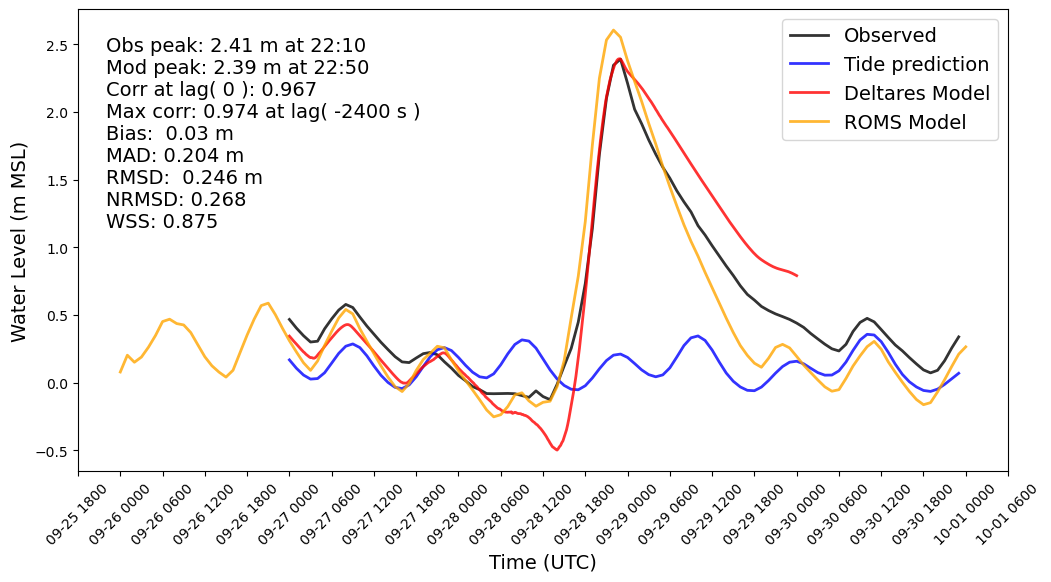

In [27]:
# Plot all three time series

fig, ax = plt.subplots(1,1, figsize=(12, 6))
plt.plot(dfN["time"], dfN["Verified (m)"], label="Observed", color="black", alpha=.8, linewidth=2)

# plt.plot(df["time"], df["obs"], label="Observed", color="k", alpha=.8, linewidth=2)
plt.plot(dfN["time"], dfN["Predicted (m)"], label="Tide prediction", alpha=.8, color="b", linewidth=2)
plt.plot(df["time"], df["mod"], label="Deltares Model", color="r", alpha=.8, linewidth=2)
plt.plot(dfR["time"], dfR["WaterLevel"], label="ROMS Model", color="orange", alpha=.8, linewidth=2)


# Set time axis to label every 6 hours
#plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H%M"))

# Improve readability
plt.xticks(rotation=45)
plt.xlabel("Time (UTC)", fontsize=14)
plt.ylabel("Water Level (m MSL)", fontsize=14)
plt.legend( fontsize=14)
plt.text(.03,.99, tsb, ha='left', va='top', transform=ax.transAxes, fontsize=14)
figdir = 'F:/crs/proj/2025_NOPP_comparison/BAMS_figure/'
plt.savefig(figdir+'BAMS_Ft_Meyers_time_series.png', dpi=200, bbox_inches='tight')
plt.savefig(figdir+'BAMS_Ft_Meyers_time_series.svg', dpi=200, bbox_inches='tight')